#### **Evaluating case-control differences in Brain Age Gap (BAG)**

As a starting point, we will investiguate differences between cases and controls,
similarly to what has been done in previous studies [[1]](#1)[[2]](#2). 

**References** \
<a id=#1>[1]</a> Kaufmann, T., van der Meer, D., Doan, N. T., Schwarz, E., Lund, M. J., Agartz, I., Alnæs, D., Barch, D. M., Baur-Streubel, R., Bertolino, A., Bettella, F., Beyer, M. K., Bøen, E., Borgwardt, S., Brandt, C. L., Buitelaar, J., Celius, E. G., Cervenka, S., Conzelmann, A., … Karolinska Schizophrenia Project (KaSP). (2019). Common brain disorders are associated with heritable patterns of apparent aging of the brain. Nature Neuroscience, 22(10), 1617–1623. https://doi.org/10.1038/s41593-019-0471-7 \
<a id=#2>[2]</a> MacSweeney, N., Beck, D., Whitmore, L., Mills, K. L., Westlye, L. T., Soest, T. von, Ferschmann, L., & Tamnes, C. K. (2024). Multimodal brain age indicators of internalising problems in early adolescence: A longitudinal investigation. Biological Psychiatry: Cognitive Neuroscience and Neuroimaging. https://doi.org/10.1016/j.bpsc.2024.11.003


In [1]:
# Imports
import os
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from tqdm import tqdm
from p_tqdm import p_map


In [2]:
# Setting up data and output paths.
repository_dir = "~/code/Gagnon_BrainAge_2025/"
data_abcd = "/Volumes/T7/BrainProfilesAssociations/ABCD/"
output_folder = "/Volumes/T7/BrainAgeStudy/"

# Create output folder if it doesn't exist.
output_dir = f"{output_folder}/BAG-Diagnosis/"
os.makedirs(output_dir, exist_ok=True)

In [3]:
# Fetch Harding font.
font_files = []
for fontpath in font_manager.findSystemFonts(fontpaths=None, fontext='ttf'):
    if "Harding".lower() in fontpath.lower():
        font_files.append(fontpath)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# Set Harding font.
plt.rcParams['font.family'] = 'Harding Text Web'

# Set the Set2 color palette as an iterable.
cmap = sns.color_palette("Set2", 8)

In [4]:
# Load the BAG dataset.
BAG_df = pd.read_csv(f"{output_folder}/BrainAge/brainAgeGaps.csv")

# Load up the diagnosis data.
diagnosis_df = pd.read_excel(f"{output_folder}/ABCD/abcd_dx_labels.xlsx")

# Create a new column for PSYPATHO if at least one column is equal to 1.
diagnosis_df["PSYPATHO"] = diagnosis_df.iloc[:, 1:].apply(lambda x: 1 if (x == 1).any() else 0, axis=1)

# Format the diagnosis data, starting by dropping the "_" in subjectkey and adding "sub-".
diagnosis_df["subjectkey"] = diagnosis_df["subjectkey"].str.replace("_", "")
diagnosis_df["subjectkey"] = "sub-" + diagnosis_df["subjectkey"]

# Loading demographic data.
demo_df = pd.read_csv(f"{output_folder}/ABCD/abcd_p_demo.csv")
demo_df = demo_df.loc[demo_df.eventname == "baseline_year_1_arm_1"]

demo_vars = [
    "src_subject_id",
    "demo_sex_v2",
    "race_ethnicity",
    "demo_prnt_ed_v2",
    "demo_prtnr_ed_v2",
    "demo_comb_income_v2",
]
demo_df = demo_df[demo_vars]
demo_df.columns = [
    "subjectkey",
    "Sex",
    "Ethnicity",
    "Parent_ed1",
    "Parent_ed2",
    "Income"
]

# Compute some demographics variables.
# Highest education level (parent). Taking the highest amongst the two parents.
demo_df.loc[:, 'Parent_ed2'] = demo_df['Parent_ed2'].replace([777, 999, np.nan], 0)
demo_df.loc[:, 'high_edu'] = demo_df[['Parent_ed1', 'Parent_ed2']].values.max(1)

# Group levels together (<13 = 1, no high school, 13-14 = 2, high school, ged or equivalent,
# 15-17 = 3, some college, 18 = 4, bachelor, >19 = 5, postgraduate)
def create_edu_groups(x):
    if x < 13:
        return 1
    elif x in [13, 14]:
        return 2
    elif x in [15, 16, 17]:
        return 3
    elif x == 18:
        return 4
    elif x in [19, 20, 21]:
        return 5
    else:
        return 0

demo_df.loc[:, 'edu_groups'] = demo_df['high_edu'].apply(create_edu_groups)

# Group levels of income together ( <6 = 1, < 50 000, 6-8 = 2, 50-100 000, >9 = 3, >100 000).
def create_income_groups(x):
    if x < 6:
        return 1
    elif x in [6, 7, 8]:
        return 2
    elif x in [9, 10]:
        return 3
    else:
        return 0

demo_df.loc[:, 'income_groups'] = demo_df['Income'].apply(create_income_groups)

# Selecting the data to merge.
demo_df = demo_df.rename(columns={"subjectkey": "sid"})
demo_df["sid"] = demo_df["sid"].str.replace("_", "")
demo_df["sid"] = "sub-" + demo_df["sid"]
demo_df = demo_df[["sid", "income_groups", "edu_groups", "Ethnicity"]]
diagnosis_df = diagnosis_df.rename(columns={"subjectkey": "sid"})

# Merge the diagnosis data with the BAG dataset.
BAG_df = BAG_df.merge(diagnosis_df, on="sid", how="left")
BAG_df = BAG_df.merge(demo_df, on="sid", how="left")

# Print the number of subjects.
print(f"Number of subjects in the BAG dataset: {BAG_df.shape[0]}")

# DO some sanity checks that there is no missing data, by printing columns with missing data.
missing_data = BAG_df.isnull().sum()
missing_columns = missing_data[missing_data > 0]
if not missing_columns.empty:
    print("Columns with missing data:")
    print(missing_columns)
else:
    print("No missing data in the BAG dataset.")

# Imputing with 0 missing diagnosis data (for ADHD, AD, OCD, BPD, ODD, CD, PTSD, PSYPATHO).
diagnosis_cols = [
    "ADHD", "AD", "DD", "OCD", "BPD", "ODD", "CD", "PTSD", "PSYPATHO"
]
for col in diagnosis_cols:
    BAG_df[col] = BAG_df[col].fillna(0)

# Impute missing income data with the median income group. (if == 0, then missing)
BAG_df["income_groups"] = BAG_df["income_groups"].replace(0, BAG_df["income_groups"].median())
# Impute missing education data with the median education group. (if == 0, then missing)
BAG_df["edu_groups"] = BAG_df["edu_groups"].replace(0, BAG_df["edu_groups"].median())
# Convert ethnicity float values to integers.
BAG_df["Ethnicity"] = BAG_df["Ethnicity"].astype(int)

# Redo the sanity checks after imputation.
missing_data = BAG_df.isnull().sum()
missing_columns = missing_data[missing_data > 0]
if not missing_columns.empty:
    print("Columns with missing data after imputation:")
    print(missing_columns)
else:
    print("No missing data in the BAG dataset after imputation.")

# Save the merged dataset.
BAG_df.to_csv(f"{output_folder}/BAG_df.csv", index=False)


/var/folders/23/p0fh1nrd473dtfz3cx_4g0j00000gn/T/ipykernel_18932/2258418650.py:15: DtypeWarning: Columns (274) have mixed types. Specify dtype option on import or set low_memory=False.
  demo_df = pd.read_csv(f"{output_folder}/ABCD/abcd_p_demo.csv")


Number of subjects in the BAG dataset: 9074
Columns with missing data:
family_id     85
ADHD         129
AD           129
OCD          129
DD           129
BPD          129
ODD          129
CD           129
PTSD         129
PSYPATHO     129
dtype: int64
Columns with missing data after imputation:
family_id    85
dtype: int64


In [5]:
# Building a function to compute the linear regression model,
# and compute the t-statistics, pval, and cohen's d.
def run_linear_model(df, X, y, covariates=None):
    """
    Run a linear regression model on the given DataFrame.
    """

    # Fetch the participants with the X variable, and the participants without any diagnosis (PSYPATHO == 0).
    cases = df[df[X] == 1]
    controls = df[df["PSYPATHO"] == 0]

    # Merge them back together.
    df = pd.concat([cases, controls], axis=0)

    # Prepare the data
    X_data = df[X]
    y_data = df[y]

    # If covariates are provided, add them to the model
    if covariates is not None:
        X_data = pd.concat([X_data, df[covariates]], axis=1)
        columns = [X] + covariates
    else:
        columns = [X]

    # Scale the data.
    X_data = pd.DataFrame(X_data, columns=columns)
    y_data = pd.DataFrame(y_data, columns=[y])

    # Add a constant to the model (intercept)
    X_data = sm.add_constant(X_data)

    # Fit the linear regression model
    mod = sm.OLS(y_data, X_data)

    results = mod.fit()

    # Get the Cohen's d for the X variable.
    t = results.tvalues[X]

    # Get sample size, in each group for variable X.
    n1 = len(df[df[X] == 1])
    n2 = len(df[df[X] == 0])

    # Compute Cohen's d.
    d = (t * (n1 + n2)) / (np.sqrt(n1 * n2) * np.sqrt(results.df_resid))

    return results, d, results.pvalues[X]


def run_permutation_test_parallel(df, X, y, covariates=None, n_permutations=1000, n_jobs=-1):
    """
    Run a permutation test in parallel using joblib.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Data containing predictors and outcomes.
    X : str
        Name of the predictor of interest (to be permuted).
    y : str
        Name of the dependent variable.
    covariates : list of str, optional
        List of covariate column names.
    n_permutations : int
        Number of permutations to run.
    n_jobs : int
        Number of parallel jobs (-1 means use all available cores).
    """

    def perm_iteration(seed):
        # Use a local RNG per process for reproducibility
        rng = np.random.default_rng(seed)
        df_shuffled = df.copy()
        df_shuffled[X] = rng.permutation(df_shuffled[X])
        _, d, _ = run_linear_model(df_shuffled, X, y, covariates)
        return d

    # Seeds ensure different shuffles in parallel
    seeds = np.random.SeedSequence().spawn(n_permutations)

    # Run permutations in parallel
    perm_results = Parallel(n_jobs=n_jobs)(
        delayed(perm_iteration)(int(s.generate_state(1)[0]))
        for s in tqdm(seeds, desc=f"Running {n_permutations} permutations in parallel for diagnosis: {X}")
    )

    return perm_results


In [123]:
# Perform the same linear regression but using the BAG corrected.
# Run the linear model for all diagnosis and all BAG.

diagnosis = ["ADHD", "AD", "OCD", "DD", "ODD", "CD", "PSYPATHO"]
regions = ["BAG_WholeBrain", "BAG_Frontal", "BAG_Temporal", "BAG_Parietal",
           "BAG_Occipital", "BAG_Subcortical", "BAG_Limbic", "BAG_Insula"]

k = 0

for i, region in enumerate(regions):
    for j, diag in enumerate(diagnosis):
        # Run the linear model.
        res, d, pval = run_linear_model(
            df=BAG_df,
            X=diag,
            y=region + "_Corrected",
            covariates=["age", "sex", "income_groups", "edu_groups",
                        "Ethnicity", "handedness"]
        )

        # Run a permutation test
        perm_results = run_permutation_test_parallel(
            df=BAG_df,
            X=diag,
            y=region + "_Corrected",
            covariates=["age", "sex", "income_groups", "edu_groups",
                        "Ethnicity", "handedness"],
            n_permutations=10000,
            n_jobs=6
        )

        # Compute the p-value from the permutation test.
        pval_perm = (np.sum(np.abs(perm_results) >= np.abs(d)) + 1) / (len(perm_results) + 1)

        # Append the results to the lists.
        if i == 0 and j == 0:
            results = pd.DataFrame({
                "Region": region,
                "Diagnosis": diag,
                "Cohen's d": d,
                "p-value": pval,
                "p-value permuted": pval_perm
            }, index=[k])
        else:
            results = pd.concat([results, pd.DataFrame({
                "Region": region,
                "Diagnosis": diag,
                "Cohen's d": d,
                "p-value": pval,
                "p-value permuted": pval_perm
            }, index=[k])]
            , axis=0, ignore_index=True)

        k += 1

# Perform FDR correction on the p-values (per diagnosis).
# Get the p-values for each diagnosis.
#for dx in diagnosis:
    # Get the p-values for the current diagnosis.
#    pval = results[results["Diagnosis"] == dx]["p-value"].values

    # Perform FDR correction.
#   pval_corrected = fdrcorrection(pval, alpha=0.05)[1]

    # Add the corrected p-values to the results DataFrame.
#    results.loc[results["Diagnosis"] == dx, "p-value corrected"] = pval_corrected

# Save the results to a CSV file.
results.to_csv(f"{output_dir}/BAGcorr_Diagnosis_results.csv", index=False)


Running 10000 permutations in parallel for diagnosis: ADHD: 100%|██████████| 10000/10000 [00:19<00:00, 515.52it/s]
Running 10000 permutations in parallel for diagnosis: AD: 100%|██████████| 10000/10000 [00:17<00:00, 582.40it/s]
Running 10000 permutations in parallel for diagnosis: OCD: 100%|██████████| 10000/10000 [00:15<00:00, 636.61it/s]
Running 10000 permutations in parallel for diagnosis: DD: 100%|██████████| 10000/10000 [00:16<00:00, 592.09it/s]
Running 10000 permutations in parallel for diagnosis: ODD: 100%|██████████| 10000/10000 [00:13<00:00, 728.06it/s]
Running 10000 permutations in parallel for diagnosis: CD: 100%|██████████| 10000/10000 [00:15<00:00, 635.53it/s]
Running 10000 permutations in parallel for diagnosis: PSYPATHO: 100%|██████████| 10000/10000 [00:17<00:00, 576.70it/s]
Running 10000 permutations in parallel for diagnosis: ADHD: 100%|██████████| 10000/10000 [00:19<00:00, 515.73it/s]
Running 10000 permutations in parallel for diagnosis: AD: 100%|██████████| 10000/100

In [124]:
# Before visualizing the data, regress out the covariates.
for i, region in tqdm(enumerate(regions), desc="Regressing out covariates"):

    # Run a linear model and fetch the residuals.
    mod = OLS(
        BAG_df[region + "_Corrected"],
        sm.add_constant(BAG_df[["age", "sex", "income_groups", "edu_groups", "Ethnicity", "handedness"]])
        ).fit()

    BAG_df[region + "_corrected_residuals"] = mod.resid



Regressing out covariates: 8it [00:00, 18.32it/s]


Plotting data: 8it [00:08,  1.03s/it]


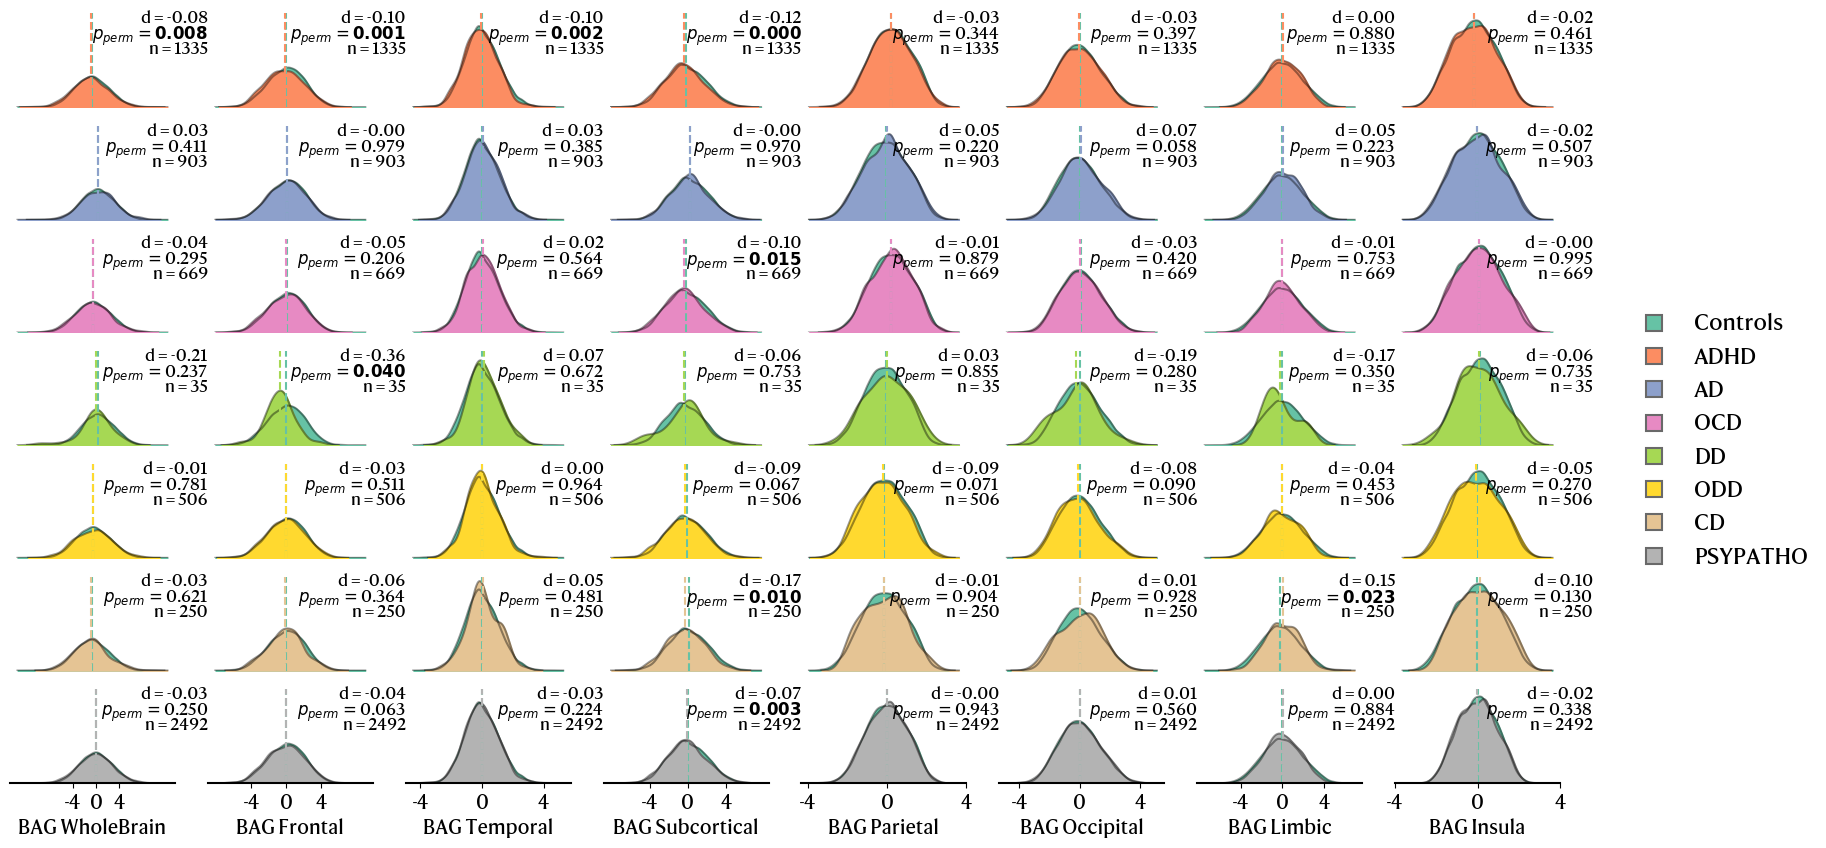

In [125]:
# Visualize the distribution of the diagnosis data compared to controls.
fig, axs = plt.subplots(7, 8, figsize=(20, 10), sharey=True)
for i, region in tqdm(enumerate(["BAG_WholeBrain", "BAG_Frontal", "BAG_Temporal",
                            "BAG_Subcortical", "BAG_Parietal", "BAG_Occipital",
                            "BAG_Limbic", "BAG_Insula"]), desc="Plotting data"):
    for j, col in enumerate(["ADHD", "AD", "OCD", "DD", "ODD", "CD", "PSYPATHO"]):
        # Create a boxplot for each diagnosis.
        cases = BAG_df[BAG_df[col] == 1]
        controls = BAG_df[BAG_df["PSYPATHO"] == 0]

        # Recreate a df with cases and controls.
        viz_df = pd.concat([cases, controls], axis=0)

        sns.kdeplot(data=viz_df, x=region + "_corrected_residuals", hue=col, ax=axs[j, i], palette=[cmap[j+1], cmap[0]],
                    fill=True, alpha=1, hue_order=[1, 0], common_norm=False, multiple="layer", legend=False)
        sns.kdeplot(data=viz_df, x=region + "_corrected_residuals", hue=col, ax=axs[j, i], palette=["black", "black"],
                    fill=False, alpha=0.4, common_norm=False, multiple="layer", legend=False)
        axs[j, i].set_xlabel("")
        axs[j, i].spines[["left", "top", "right"]].set_visible(False)
        axs[j, i].set_yticks([])
        axs[j, i].set_ylabel("")
        #axs[j, i].set_xlim([-3, 3])

        #if i == 0 or i == 1 or i == 3:
        #    axs[j, i].set_xlim([-6, 6])

        if j < 6:
            axs[j, i].spines["bottom"].set_visible(False)
            axs[j, i].set_xticks([])
        else:
            axs[j, i].set_xticks([-4, 0, 4])
            axs[j, i].set_xticklabels([-4, 0, 4], fontsize=14)

            # String "_" from the region name.
            region_lab = region.replace("_", " ")
            axs[j, i].set_xlabel(region_lab, fontsize=14)
            axs[j, i].spines["bottom"].set_linewidth(1.5)
        
        # Write the Cohen's d and p-values on the plot.
        # Fetch the Cohen's d and p-values.
        d = results.loc[(results["Region"] == region) & (results["Diagnosis"] == col), "Cohen's d"].values[0]
        pval = results.loc[(results["Region"] == region) & (results["Diagnosis"] == col), "p-value"].values[0]
        pval_corrected = results.loc[(results["Region"] == region) & (results["Diagnosis"] == col), "p-value permuted"].values[0]
        n = len(viz_df[viz_df[col] == 1])

        # Format p-values: bold if significant
        if pval_corrected < 0.05:
            pval_corrected_text = r"$p_{perm}=$" + r"$\mathbf{" + f"{pval_corrected:.3f}" + "}$"
        else:
            pval_corrected_text = r"$p_{perm}=$" + f"{pval_corrected:.3f}"

        axs[j, i].text(1.2, 0.95, f"d = {d:.2f}", ha="right", va="center",
                       transform=axs[j, i].transAxes, fontsize=12)
        axs[j, i].text(1.2, 0.75, pval_corrected_text, ha="right", va="center",
                        transform=axs[j, i].transAxes, fontsize=12)
        axs[j, i].text(1.2, 0.62, f"n = {n}", ha="right", va="center",
                        transform=axs[j, i].transAxes, fontsize=12)

        # Add a dashed line for the mean of both groups.
        mean_control = np.mean(viz_df[viz_df["PSYPATHO"] == 0][region + "_corrected_residuals"])
        mean_diag = np.mean(viz_df[viz_df[col] == 1][region + "_corrected_residuals"])
        axs[j, i].axvline(mean_control, color=cmap[0], linestyle="--", linewidth=1.5)
        axs[j, i].axvline(mean_diag, color=cmap[j+1], linestyle="--", linewidth=1.5)

# Add a global legend highlighting the colors for the diagnoses with a border.
handles = [plt.Line2D([0], [0], color=cmap[j], markersize=12, lw=0, marker="s", markeredgewidth=1.5, markeredgecolor='dimgrey') for j in range(8)]
labels = ["Controls", "ADHD", "AD", "OCD", "DD", "ODD", "CD", "PSYPATHO"]
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.98, 0.6),
           ncol=1, fontsize=16, frameon=False)

plt.savefig(f"{output_folder}/BAG-Diagnosis/diagnosis_kde_corrected.png", dpi=300, bbox_inches="tight")


### **Assessing the differences in effect sizes with two different bias correction methods**

In [6]:
# Perform the same linear regression but using the BAG corrected from Beheshti and Cole
# Run the linear model for all diagnosis and all BAG.

diagnosis = ["ADHD", "AD", "OCD", "DD", "ODD", "CD", "PSYPATHO"]
regions = ["BAG_WholeBrain_Corrected", "BAG_WholeBrain_Corrected_Cole"]

k = 0

for i, region in enumerate(regions):
    for j, diag in enumerate(diagnosis):
        # Run the linear model.
        res, d, pval = run_linear_model(
            df=BAG_df,
            X=diag,
            y=region,
            covariates=["age", "sex", "income_groups", "edu_groups",
                        "Ethnicity", "handedness"]
        )

        # Run a permutation test
        perm_results = run_permutation_test_parallel(
            df=BAG_df,
            X=diag,
            y=region,
            covariates=["age", "sex", "income_groups", "edu_groups",
                        "Ethnicity", "handedness"],
            n_permutations=10000,
            n_jobs=6
        )

        # Compute the p-value from the permutation test.
        pval_perm = (np.sum(np.abs(perm_results) >= np.abs(d)) + 1) / (len(perm_results) + 1)

        # Append the results to the lists.
        if i == 0 and j == 0:
            results_correction_methods = pd.DataFrame({
                "Region": region,
                "Diagnosis": diag,
                "Cohen's d": d,
                "p-value": pval,
                "p-value permuted": pval_perm
            }, index=[k])
        else:
            results_correction_methods = pd.concat([results_correction_methods, pd.DataFrame({
                "Region": region,
                "Diagnosis": diag,
                "Cohen's d": d,
                "p-value": pval,
                "p-value permuted": pval_perm
            }, index=[k])]
            , axis=0, ignore_index=True)

        k += 1

# Perform FDR correction on the p-values (per diagnosis).
# Get the p-values for each diagnosis.
#for dx in diagnosis:
    # Get the p-values for the current diagnosis.
#    pval = results[results["Diagnosis"] == dx]["p-value"].values

    # Perform FDR correction.
#   pval_corrected = fdrcorrection(pval, alpha=0.05)[1]

    # Add the corrected p-values to the results DataFrame.
#    results.loc[results["Diagnosis"] == dx, "p-value corrected"] = pval_corrected

# Save the results to a CSV file.
results_correction_methods.to_csv(f"{output_dir}/BAGcorr_correction_methods_results.csv", index=False)


Running 10000 permutations in parallel for diagnosis: ADHD: 100%|██████████| 10000/10000 [00:17<00:00, 580.80it/s]
Running 10000 permutations in parallel for diagnosis: AD: 100%|██████████| 10000/10000 [00:12<00:00, 799.83it/s]
Running 10000 permutations in parallel for diagnosis: OCD: 100%|██████████| 10000/10000 [00:11<00:00, 855.40it/s]
Running 10000 permutations in parallel for diagnosis: DD: 100%|██████████| 10000/10000 [00:10<00:00, 971.48it/s]
Running 10000 permutations in parallel for diagnosis: ODD: 100%|██████████| 10000/10000 [00:11<00:00, 858.77it/s]
Running 10000 permutations in parallel for diagnosis: CD: 100%|██████████| 10000/10000 [00:09<00:00, 1006.39it/s]
Running 10000 permutations in parallel for diagnosis: PSYPATHO: 100%|██████████| 10000/10000 [00:10<00:00, 921.13it/s]
Running 10000 permutations in parallel for diagnosis: ADHD: 100%|██████████| 10000/10000 [00:10<00:00, 961.07it/s]
Running 10000 permutations in parallel for diagnosis: AD: 100%|██████████| 10000/10

In [9]:
# Before visualizing the data, regress out the covariates.
for i, region in tqdm(enumerate(regions), desc="Regressing out covariates"):

    # Run a linear model and fetch the residuals.
    mod = OLS(
        BAG_df[region],
        sm.add_constant(BAG_df[["age", "sex", "income_groups", "edu_groups", "Ethnicity", "handedness"]])
        ).fit()

    BAG_df[region + "_corrected_residuals"] = mod.resid



Regressing out covariates: 2it [00:00, 12.74it/s]


Plotting data: 2it [00:01,  1.57it/s]


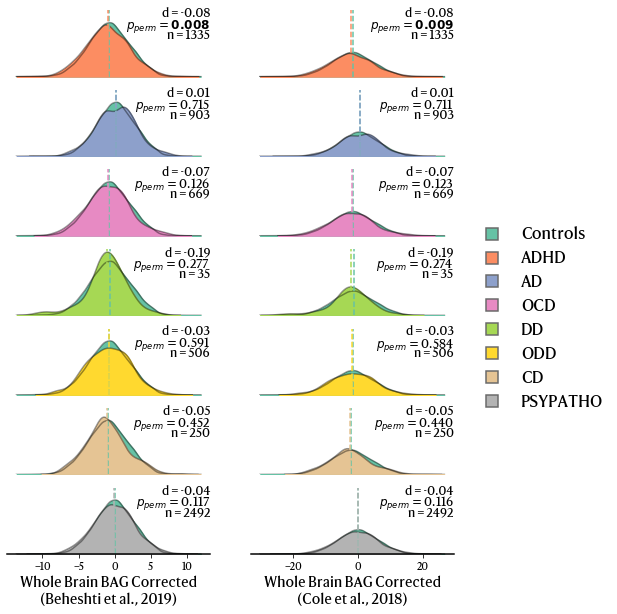

In [21]:
# Visualize the distribution of the diagnosis data compared to controls.
fig, axs = plt.subplots(7, 2, figsize=(8, 10), sharey=True)
for i, region in tqdm(enumerate(["BAG_WholeBrain_Corrected", "BAG_WholeBrain_Corrected_Cole"]), desc="Plotting data"):
    for j, col in enumerate(["ADHD", "AD", "OCD", "DD", "ODD", "CD", "PSYPATHO"]):
        # Create a boxplot for each diagnosis.
        cases = BAG_df[BAG_df[col] == 1]
        controls = BAG_df[BAG_df["PSYPATHO"] == 0]

        # Recreate a df with cases and controls.
        viz_df = pd.concat([cases, controls], axis=0)

        sns.kdeplot(data=viz_df, x=region + "_corrected_residuals", hue=col, ax=axs[j, i], palette=[cmap[j+1], cmap[0]],
                    fill=True, alpha=1, hue_order=[1, 0], common_norm=False, multiple="layer", legend=False)
        sns.kdeplot(data=viz_df, x=region + "_corrected_residuals", hue=col, ax=axs[j, i], palette=["black", "black"],
                    fill=False, alpha=0.4, common_norm=False, multiple="layer", legend=False)
        axs[j, i].set_xlabel("")
        axs[j, i].spines[["left", "top", "right"]].set_visible(False)
        axs[j, i].set_yticks([])
        axs[j, i].set_ylabel("")
        #axs[j, i].set_xlim([-3, 3])

        #if i == 0 or i == 1 or i == 3:
        #    axs[j, i].set_xlim([-6, 6])

        if j < 6:
            axs[j, i].spines["bottom"].set_visible(False)
            axs[j, i].set_xticks([])
        else:
            #axs[j, i].set_xticks([-4, 0, 4])
            #axs[j, i].set_xticklabels([-4, 0, 4], fontsize=14)

            # String "_" from the region name.
            if i == 0:
                region_lab = "Whole Brain BAG Corrected\n(Beheshti et al., 2019)"
            else:
                region_lab = "Whole Brain BAG Corrected\n(Cole et al., 2018)"
            axs[j, i].set_xlabel(region_lab, fontsize=14)
            axs[j, i].spines["bottom"].set_linewidth(1.5)
        
        # Write the Cohen's d and p-values on the plot.
        # Fetch the Cohen's d and p-values.
        d = results_correction_methods.loc[(results_correction_methods["Region"] == region) & (results_correction_methods["Diagnosis"] == col), "Cohen's d"].values[0]
        pval = results_correction_methods.loc[(results_correction_methods["Region"] == region) & (results_correction_methods["Diagnosis"] == col), "p-value"].values[0]
        pval_corrected = results_correction_methods.loc[(results_correction_methods["Region"] == region) & (results_correction_methods["Diagnosis"] == col), "p-value permuted"].values[0]
        n = len(viz_df[viz_df[col] == 1])

        # Format p-values: bold if significant
        if pval_corrected < 0.05:
            pval_corrected_text = r"$p_{perm}=$" + r"$\mathbf{" + f"{pval_corrected:.3f}" + "}$"
        else:
            pval_corrected_text = r"$p_{perm}=$" + f"{pval_corrected:.3f}"

        axs[j, i].text(1, 0.95, f"d = {d:.2f}", ha="right", va="center",
                       transform=axs[j, i].transAxes, fontsize=12)
        axs[j, i].text(1, 0.75, pval_corrected_text, ha="right", va="center",
                        transform=axs[j, i].transAxes, fontsize=12)
        axs[j, i].text(1, 0.62, f"n = {n}", ha="right", va="center",
                        transform=axs[j, i].transAxes, fontsize=12)

        # Add a dashed line for the mean of both groups.
        mean_control = np.mean(viz_df[viz_df["PSYPATHO"] == 0][region + "_corrected_residuals"])
        mean_diag = np.mean(viz_df[viz_df[col] == 1][region + "_corrected_residuals"])
        axs[j, i].axvline(mean_control, color=cmap[0], linestyle="--", linewidth=1.5)
        axs[j, i].axvline(mean_diag, color=cmap[j+1], linestyle="--", linewidth=1.5)

# Add a global legend highlighting the colors for the diagnoses with a border.
handles = [plt.Line2D([0], [0], color=cmap[j], markersize=12, lw=0, marker="s", markeredgewidth=1.5, markeredgecolor='dimgrey') for j in range(8)]
labels = ["Controls", "ADHD", "AD", "OCD", "DD", "ODD", "CD", "PSYPATHO"]
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(1.05, 0.6),
           ncol=1, fontsize=16, frameon=False)

plt.savefig(f"{output_folder}/BAG-Diagnosis/kde_correction_methods.png", dpi=300, bbox_inches="tight")


### **Evaluating case-control differences in the male and female subsets**

In [35]:
BAG_male_df = pd.read_csv(f"{output_folder}/BrainAge/brainAgeGapsMale.csv")

# Merge with diagnosis and demographics data.
BAG_male_df = BAG_male_df.merge(diagnosis_df, on="sid", how="left")
BAG_male_df = BAG_male_df.merge(demo_df, on="sid", how="left")

# Fill missing diagnosis data with 0.
for col in diagnosis_cols:
    BAG_male_df.loc[:, col] = BAG_male_df.loc[:, col].fillna(0)

# Replace the 0 value in income and education groups with the median value.
for col in ["income_groups", "edu_groups"]:
    BAG_male_df.loc[BAG_male_df[col] == 0, col] = BAG_male_df[col].median()

# Convert ethnicity float values to integers.
BAG_male_df["Ethnicity"] = BAG_male_df["Ethnicity"].astype(int)

# Save the df.
BAG_male_df.to_csv(f"{output_folder}/BAG_male.csv", index=False)

In [114]:
# Perform the same linear regression but using the BAG corrected.
# Run the linear model for all diagnosis and all BAG.

diagnosis = ["ADHD", "AD", "OCD", "DD", "ODD", "CD", "PSYPATHO"]
regions = ["BAG_WholeBrain", "BAG_Frontal", "BAG_Temporal", "BAG_Parietal",
           "BAG_Occipital", "BAG_Subcortical", "BAG_Limbic", "BAG_Insula"]

k = 0

for i, region in enumerate(regions):
    for j, diag in enumerate(diagnosis):
        # Run the linear model.
        res, d, pval = run_linear_model(
            df=BAG_male_df,
            X=diag,
            y=region + "_Corrected",
            covariates=["age", "income_groups", "edu_groups",
                        "Ethnicity", "handedness"]
        )

        # Run a permutation test
        perm_results = run_permutation_test_parallel(
            df=BAG_male_df,
            X=diag,
            y=region + "_Corrected",
            covariates=["age", "income_groups", "edu_groups",
                        "Ethnicity", "handedness"],
            n_permutations=10000
        )

        # Compute the p-value from the permutation test.
        pval_perm = (np.sum(np.abs(perm_results) >= np.abs(d)) + 1) / (len(perm_results) + 1)

        # Append the results to the lists.
        if i == 0 and j == 0:
            results = pd.DataFrame({
                "Region": region,
                "Diagnosis": diag,
                "Cohen's d": d,
                "p-value": pval,
                "p-value permuted": pval_perm
            }, index=[k])
        else:
            results = pd.concat([results, pd.DataFrame({
                "Region": region,
                "Diagnosis": diag,
                "Cohen's d": d,
                "p-value": pval,
                "p-value permuted": pval_perm
            }, index=[k])]
            , axis=0, ignore_index=True)

        k += 1

# Perform FDR correction on the p-values (per diagnosis).
# Get the p-values for each diagnosis.
#for dx in diagnosis:
    # Get the p-values for the current diagnosis.
#    pval = results[results["Diagnosis"] == dx]["p-value"].values

    # Perform FDR correction.
#   pval_corrected = fdrcorrection(pval, alpha=0.05)[1]

    # Add the corrected p-values to the results DataFrame.
#    results.loc[results["Diagnosis"] == dx, "p-value corrected"] = pval_corrected

# Save the results to a CSV file.
results.to_csv(f"{output_dir}/BAGcorr_Diagnosis_Male_results.csv", index=False)


Running 10000 permutations in parallel for diagnosis: ADHD: 100%|██████████| 10000/10000 [00:10<00:00, 919.85it/s]
Running 10000 permutations in parallel for diagnosis: AD: 100%|██████████| 10000/10000 [00:07<00:00, 1312.24it/s]
Running 10000 permutations in parallel for diagnosis: OCD: 100%|██████████| 10000/10000 [00:06<00:00, 1428.71it/s]
Running 10000 permutations in parallel for diagnosis: DD: 100%|██████████| 10000/10000 [00:06<00:00, 1539.23it/s]
Running 10000 permutations in parallel for diagnosis: ODD: 100%|██████████| 10000/10000 [00:08<00:00, 1242.84it/s]
Running 10000 permutations in parallel for diagnosis: CD: 100%|██████████| 10000/10000 [00:07<00:00, 1384.28it/s]
Running 10000 permutations in parallel for diagnosis: PSYPATHO: 100%|██████████| 10000/10000 [00:08<00:00, 1194.55it/s]
Running 10000 permutations in parallel for diagnosis: ADHD: 100%|██████████| 10000/10000 [00:07<00:00, 1269.47it/s]
Running 10000 permutations in parallel for diagnosis: AD: 100%|██████████| 10

In [115]:
# Before visualizing the data, regress out the covariates.
for i, region in tqdm(enumerate(regions), desc="Regressing out covariates"):

    # Run a linear model and fetch the residuals.
    mod = OLS(
        BAG_male_df[region + "_Corrected"],
        sm.add_constant(BAG_male_df[["age", "income_groups", "edu_groups", "Ethnicity", "handedness"]])
        ).fit()

    BAG_male_df[region + "_corrected_residuals"] = mod.resid



Regressing out covariates: 8it [00:00, 88.92it/s]


Plotting data: 8it [00:07,  1.08it/s]


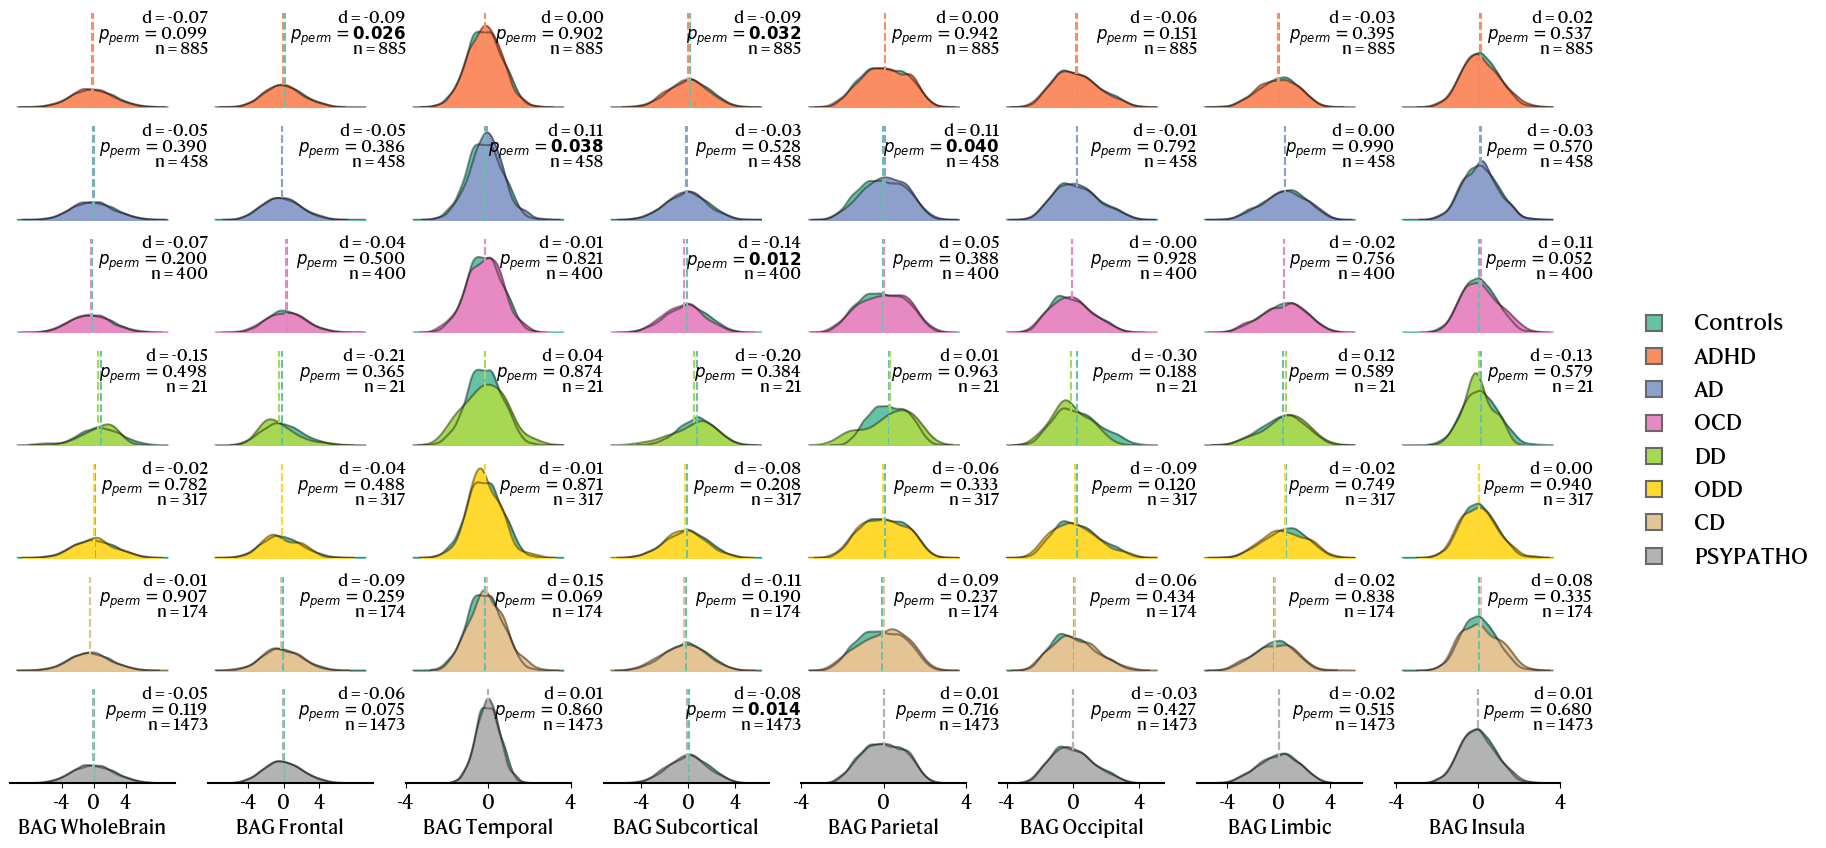

In [116]:
# Visualize the distribution of the diagnosis data compared to controls.
fig, axs = plt.subplots(7, 8, figsize=(20, 10), sharey=True)
for i, region in tqdm(enumerate(["BAG_WholeBrain", "BAG_Frontal", "BAG_Temporal",
                            "BAG_Subcortical", "BAG_Parietal", "BAG_Occipital",
                            "BAG_Limbic", "BAG_Insula"]), desc="Plotting data"):
    for j, col in enumerate(["ADHD", "AD", "OCD", "DD", "ODD", "CD", "PSYPATHO"]):
        # Create a boxplot for each diagnosis.
        cases = BAG_male_df[BAG_male_df[col] == 1]
        controls = BAG_male_df[BAG_male_df["PSYPATHO"] == 0]

        # Recreate a df with cases and controls.
        viz_df = pd.concat([cases, controls], axis=0)

        sns.kdeplot(data=viz_df, x=region + "_corrected_residuals", hue=col, ax=axs[j, i], palette=[cmap[j+1], cmap[0]],
                    fill=True, alpha=1, hue_order=[1, 0], common_norm=False, multiple="layer", legend=False)
        sns.kdeplot(data=viz_df, x=region + "_corrected_residuals", hue=col, ax=axs[j, i], palette=["black", "black"],
                    fill=False, alpha=0.4, common_norm=False, multiple="layer", legend=False)
        axs[j, i].set_xlabel("")
        axs[j, i].spines[["left", "top", "right"]].set_visible(False)
        axs[j, i].set_yticks([])
        axs[j, i].set_ylabel("")
        #axs[j, i].set_xlim([-3, 3])

        #if i == 0 or i == 1 or i == 3:
        #    axs[j, i].set_xlim([-6, 6])

        if j < 6:
            axs[j, i].spines["bottom"].set_visible(False)
            axs[j, i].set_xticks([])
        else:
            axs[j, i].set_xticks([-4, 0, 4])
            axs[j, i].set_xticklabels([-4, 0, 4], fontsize=14)

            # String "_" from the region name.
            region_lab = region.replace("_", " ")
            axs[j, i].set_xlabel(region_lab, fontsize=14)
            axs[j, i].spines["bottom"].set_linewidth(1.5)
        
        # Write the Cohen's d and p-values on the plot.
        # Fetch the Cohen's d and p-values.
        d = results.loc[(results["Region"] == region) & (results["Diagnosis"] == col), "Cohen's d"].values[0]
        pval = results.loc[(results["Region"] == region) & (results["Diagnosis"] == col), "p-value"].values[0]
        pval_corrected = results.loc[(results["Region"] == region) & (results["Diagnosis"] == col), "p-value permuted"].values[0]
        n = len(viz_df[viz_df[col] == 1])

        # Format p-values: bold if significant
        if pval_corrected < 0.05:
            pval_corrected_text = r"$p_{perm}=$" + r"$\mathbf{" + f"{pval_corrected:.3f}" + "}$"
        else:
            pval_corrected_text = r"$p_{perm}=$" + f"{pval_corrected:.3f}"

        axs[j, i].text(1.2, 0.95, f"d = {d:.2f}", ha="right", va="center",
                       transform=axs[j, i].transAxes, fontsize=12)
        axs[j, i].text(1.2, 0.75, pval_corrected_text, ha="right", va="center",
                        transform=axs[j, i].transAxes, fontsize=12)
        axs[j, i].text(1.2, 0.62, f"n = {n}", ha="right", va="center",
                        transform=axs[j, i].transAxes, fontsize=12)

        # Add a dashed line for the mean of both groups.
        mean_control = np.mean(viz_df[viz_df["PSYPATHO"] == 0][region + "_corrected_residuals"])
        mean_diag = np.mean(viz_df[viz_df[col] == 1][region + "_corrected_residuals"])
        axs[j, i].axvline(mean_control, color=cmap[0], linestyle="--", linewidth=1.5)
        axs[j, i].axvline(mean_diag, color=cmap[j+1], linestyle="--", linewidth=1.5)

# Add a global legend highlighting the colors for the diagnoses with a border.
handles = [plt.Line2D([0], [0], color=cmap[j], markersize=12, lw=0, marker="s", markeredgewidth=1.5, markeredgecolor='dimgrey') for j in range(8)]
labels = ["Controls", "ADHD", "AD", "OCD", "DD", "ODD", "CD", "PSYPATHO"]
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.98, 0.6),
           ncol=1, fontsize=16, frameon=False)

plt.savefig(f"{output_folder}/BAG-Diagnosis/diagnosis_kde_corrected_male.png", dpi=300, bbox_inches="tight")


In [36]:
BAG_female_df = pd.read_csv(f"{output_folder}/BrainAge/brainAgeGapsFemale.csv")

# Merge with diagnosis and demographics data.
BAG_female_df = BAG_female_df.merge(diagnosis_df, on="sid", how="left")
BAG_female_df = BAG_female_df.merge(demo_df, on="sid", how="left")

# Fill missing diagnosis data with 0.
for col in diagnosis_cols:
    BAG_female_df.loc[:, col] = BAG_female_df.loc[:, col].fillna(0)

# Replace the 0 value in income and education groups with the median value.
for col in ["income_groups", "edu_groups"]:
    BAG_female_df.loc[BAG_female_df[col] == 0, col] = BAG_female_df[col].median()

# Convert ethnicity float values to integers.
BAG_female_df["Ethnicity"] = BAG_female_df["Ethnicity"].astype(int)

# Save the df.
BAG_female_df.to_csv(f"{output_folder}/BAG_female.csv", index=False)


In [92]:
# Perform the same linear regression but using the BAG corrected.
# Run the linear model for all diagnosis and all BAG.

diagnosis = ["ADHD", "AD", "OCD", "DD", "ODD", "CD", "PSYPATHO"]
regions = ["BAG_WholeBrain", "BAG_Frontal", "BAG_Temporal", "BAG_Parietal",
           "BAG_Occipital", "BAG_Subcortical", "BAG_Limbic", "BAG_Insula"]

k = 0

for i, region in enumerate(regions):
    for j, diag in enumerate(diagnosis):
        # Run the linear model.
        res, d, pval = run_linear_model(
            df=BAG_female_df,
            X=diag,
            y=region + "_Corrected",
            covariates=["age", "income_groups", "edu_groups",
                        "Ethnicity", "handedness"]
        )

        # Run a permutation test
        perm_results = run_permutation_test_parallel(
            df=BAG_female_df,
            X=diag,
            y=region + "_Corrected",
            covariates=["age", "income_groups", "edu_groups",
                        "Ethnicity", "handedness"],
            n_permutations=10000
        )

        # Compute the p-value from the permutation test.
        pval_perm = (np.sum(np.abs(perm_results) >= np.abs(d)) + 1) / (len(perm_results) + 1)

        # Append the results to the lists.
        if i == 0 and j == 0:
            results = pd.DataFrame({
                "Region": region,
                "Diagnosis": diag,
                "Cohen's d": d,
                "p-value": pval,
                "p-value permuted": pval_perm
            }, index=[k])
        else:
            results = pd.concat([results, pd.DataFrame({
                "Region": region,
                "Diagnosis": diag,
                "Cohen's d": d,
                "p-value": pval,
                "p-value permuted": pval_perm
            }, index=[k])]
            , axis=0, ignore_index=True)

        k += 1

# Perform FDR correction on the p-values (per diagnosis).
# Get the p-values for each diagnosis.
#for dx in diagnosis:
    # Get the p-values for the current diagnosis.
#    pval = results[results["Diagnosis"] == dx]["p-value"].values

    # Perform FDR correction.
#   pval_corrected = fdrcorrection(pval, alpha=0.05)[1]

    # Add the corrected p-values to the results DataFrame.
#    results.loc[results["Diagnosis"] == dx, "p-value corrected"] = pval_corrected

# Save the results to a CSV file.
results.to_csv(f"{output_dir}/BAGcorr_Diagnosis_Female_results.csv", index=False)


Running 10000 permutations in parallel for diagnosis: ADHD: 100%|██████████| 10000/10000 [00:08<00:00, 1222.33it/s]
Running 10000 permutations in parallel for diagnosis: AD: 100%|██████████| 10000/10000 [00:06<00:00, 1450.62it/s]
Running 10000 permutations in parallel for diagnosis: OCD: 100%|██████████| 10000/10000 [00:06<00:00, 1631.03it/s]
Running 10000 permutations in parallel for diagnosis: DD: 100%|██████████| 10000/10000 [00:06<00:00, 1592.61it/s]
Running 10000 permutations in parallel for diagnosis: ODD: 100%|██████████| 10000/10000 [00:06<00:00, 1611.96it/s]
Running 10000 permutations in parallel for diagnosis: CD: 100%|██████████| 10000/10000 [00:06<00:00, 1523.87it/s]
Running 10000 permutations in parallel for diagnosis: PSYPATHO: 100%|██████████| 10000/10000 [00:07<00:00, 1289.98it/s]
Running 10000 permutations in parallel for diagnosis: ADHD: 100%|██████████| 10000/10000 [00:06<00:00, 1465.16it/s]
Running 10000 permutations in parallel for diagnosis: AD: 100%|██████████| 1

In [93]:
# Before visualizing the data, regress out the covariates.
for i, region in tqdm(enumerate(regions), desc="Regressing out covariates"):

    # Run a linear model and fetch the residuals.
    mod = OLS(
        BAG_female_df[region + "_Corrected"],
        sm.add_constant(BAG_female_df[["age", "income_groups", "edu_groups", "Ethnicity", "handedness"]])
        ).fit()

    BAG_female_df[region + "_corrected_residuals"] = mod.resid



Regressing out covariates: 0it [00:00, ?it/s]

Regressing out covariates: 8it [00:00, 54.91it/s]


Plotting data: 8it [00:06,  1.17it/s]


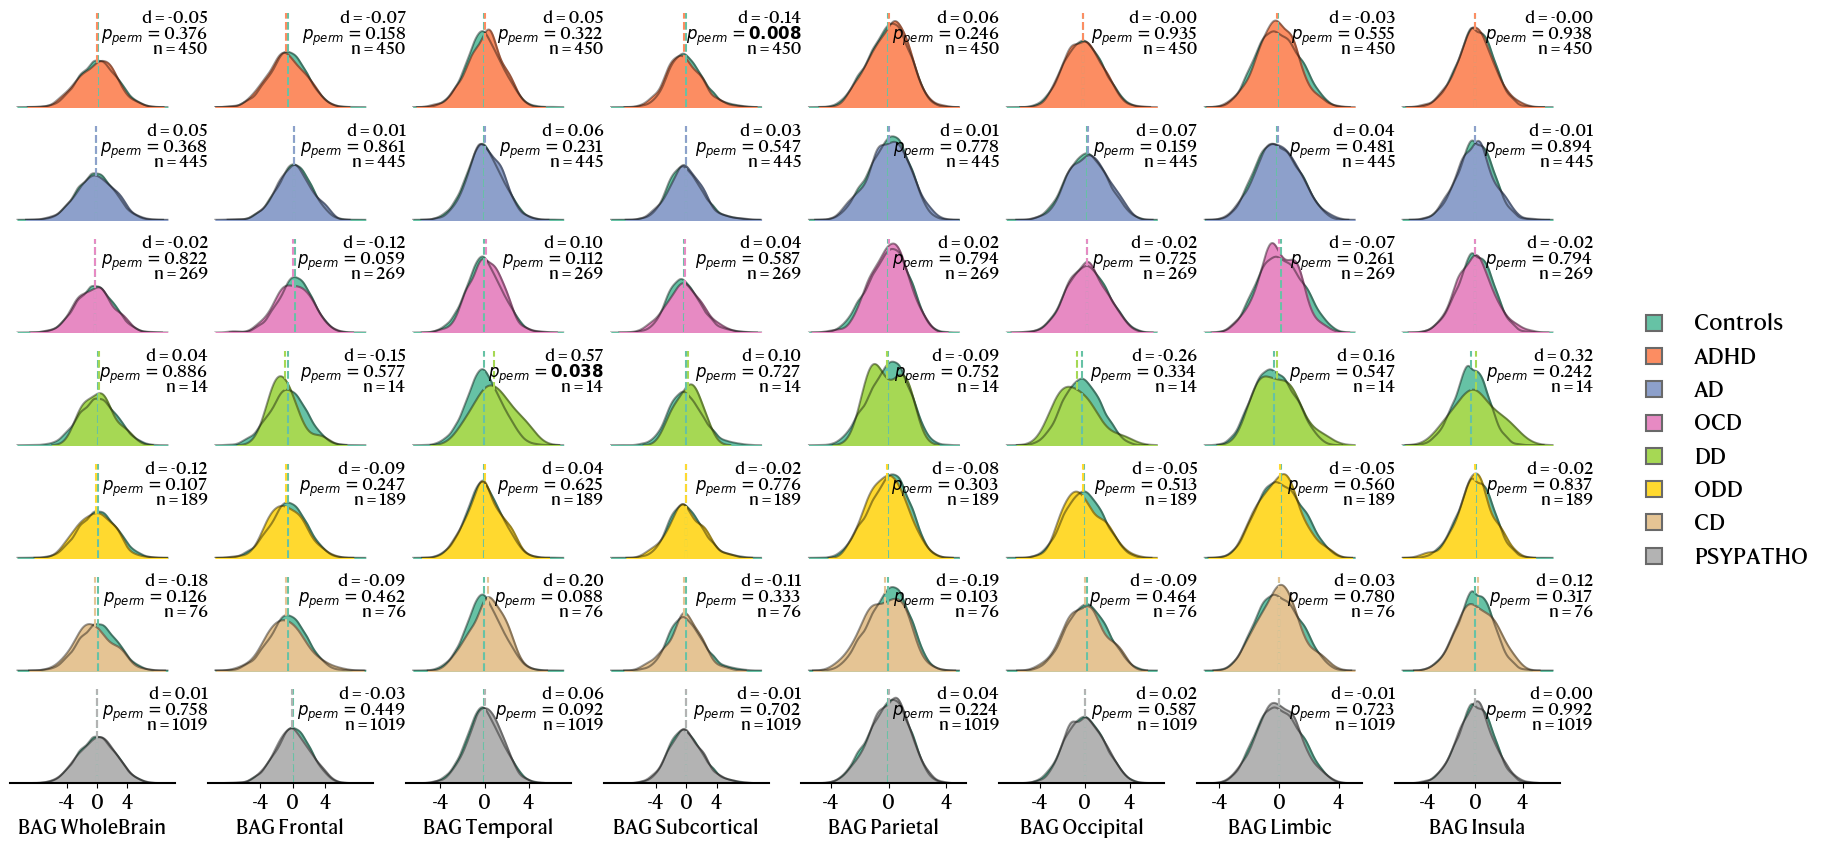

In [104]:
# Visualize the distribution of the diagnosis data compared to controls.
fig, axs = plt.subplots(7, 8, figsize=(20, 10), sharey=True)
for i, region in tqdm(enumerate(["BAG_WholeBrain", "BAG_Frontal", "BAG_Temporal",
                            "BAG_Subcortical", "BAG_Parietal", "BAG_Occipital",
                            "BAG_Limbic", "BAG_Insula"]), desc="Plotting data"):
    for j, col in enumerate(["ADHD", "AD", "OCD", "DD", "ODD", "CD", "PSYPATHO"]):
        # Create a boxplot for each diagnosis.
        cases = BAG_female_df[BAG_female_df[col] == 1]
        controls = BAG_female_df[BAG_female_df["PSYPATHO"] == 0]

        # Recreate a df with cases and controls.
        viz_df = pd.concat([cases, controls], axis=0)

        sns.kdeplot(data=viz_df, x=region + "_corrected_residuals", hue=col, ax=axs[j, i], palette=[cmap[j+1], cmap[0]],
                    fill=True, alpha=1, hue_order=[1, 0], common_norm=False, multiple="layer", legend=False)
        sns.kdeplot(data=viz_df, x=region + "_corrected_residuals", hue=col, ax=axs[j, i], palette=["black", "black"],
                    fill=False, alpha=0.4, common_norm=False, multiple="layer", legend=False)
        axs[j, i].set_xlabel("")
        axs[j, i].spines[["left", "top", "right"]].set_visible(False)
        axs[j, i].set_yticks([])
        axs[j, i].set_ylabel("")
        #axs[j, i].set_xlim([-3, 3])

        #if i == 0 or i == 1 or i == 3:
        #    axs[j, i].set_xlim([-6, 6])

        if j < 6:
            axs[j, i].spines["bottom"].set_visible(False)
            axs[j, i].set_xticks([])
        else:
            axs[j, i].set_xticks([-4, 0, 4])
            axs[j, i].set_xticklabels([-4, 0, 4], fontsize=14)

            # String "_" from the region name.
            region_lab = region.replace("_", " ")
            axs[j, i].set_xlabel(region_lab, fontsize=14)
            axs[j, i].spines["bottom"].set_linewidth(1.5)
        
        # Write the Cohen's d and p-values on the plot.
        # Fetch the Cohen's d and p-values.
        d = results.loc[(results["Region"] == region) & (results["Diagnosis"] == col), "Cohen's d"].values[0]
        pval = results.loc[(results["Region"] == region) & (results["Diagnosis"] == col), "p-value"].values[0]
        pval_corrected = results.loc[(results["Region"] == region) & (results["Diagnosis"] == col), "p-value permuted"].values[0]
        n = len(viz_df[viz_df[col] == 1])

        # Format p-values: bold if significant
        if pval_corrected < 0.05:
            pval_corrected_text = r"$p_{perm}=$" + r"$\mathbf{" + f"{pval_corrected:.3f}" + "}$"
        else:
            pval_corrected_text = r"$p_{perm}=$" + f"{pval_corrected:.3f}"

        axs[j, i].text(1.2, 0.95, f"d = {d:.2f}", ha="right", va="center",
                       transform=axs[j, i].transAxes, fontsize=12)
        axs[j, i].text(1.2, 0.75, pval_corrected_text, ha="right", va="center",
                        transform=axs[j, i].transAxes, fontsize=12)
        axs[j, i].text(1.2, 0.62, f"n = {n}", ha="right", va="center",
                        transform=axs[j, i].transAxes, fontsize=12)

        # Add a dashed line for the mean of both groups.
        mean_control = np.mean(viz_df[viz_df["PSYPATHO"] == 0][region + "_corrected_residuals"])
        mean_diag = np.mean(viz_df[viz_df[col] == 1][region + "_corrected_residuals"])
        axs[j, i].axvline(mean_control, color=cmap[0], linestyle="--", linewidth=1.5)
        axs[j, i].axvline(mean_diag, color=cmap[j+1], linestyle="--", linewidth=1.5)

# Add a global legend highlighting the colors for the diagnoses with a border.
handles = [plt.Line2D([0], [0], color=cmap[j], markersize=12, lw=0, marker="s", markeredgewidth=1.5, markeredgecolor='dimgrey') for j in range(8)]
labels = ["Controls", "ADHD", "AD", "OCD", "DD", "ODD", "CD", "PSYPATHO"]
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.98, 0.6),
           ncol=1, fontsize=16, frameon=False)

plt.savefig(f"{output_folder}/BAG-Diagnosis/diagnosis_kde_corrected_female.png", dpi=300, bbox_inches="tight")


#### **Load back the results to apply multiple comparison**

Since we performed a few statistical tests, we need to apply multiple comparison correction.

In [5]:
# Load back the results.
results = pd.read_csv(f"{output_dir}/BAGcorr_Diagnosis_results.csv")
results_f = pd.read_csv(f"{output_dir}/BAGcorr_Diagnosis_Female_results.csv")
results_m = pd.read_csv(f"{output_dir}/BAGcorr_Diagnosis_Male_results.csv")

In [10]:
# Apply multiple correction using the fdr_tsbky from statsmodel.
dx = ["AD", "ADHD", "CD", "DD", "OCD", "ODD", "PSYPATHO"]

# Iterate over dx to apply correction on p-value permuted.
for d in dx:
    pvals = results.loc[results["Diagnosis"] == d, "p-value permuted"].values
    results.loc[results["Diagnosis"] == d, "p-value permuted corrected"] = multipletests(pvals, alpha=0.05, method="fdr_tsbh")[1]

    pvals_f = results_f.loc[results_f["Diagnosis"] == d, "p-value permuted"].values
    results_f.loc[results_f["Diagnosis"] == d, "p-value permuted corrected"] = multipletests(pvals_f, alpha=0.05, method="fdr_tsbh")[1]

    pvals_m = results_m.loc[results_m["Diagnosis"] == d, "p-value permuted"].values
    results_m.loc[results_m["Diagnosis"] == d, "p-value permuted corrected"] = multipletests(pvals_m, alpha=0.05, method="fdr_tsbh")[1]

# Optionally save corrected results
results.to_csv(f"{output_dir}/BAGcorr_Diagnosis_results_fdr_tsbh.csv", index=False)
results_f.to_csv(f"{output_dir}/BAGcorr_Diagnosis_Female_results_fdr_tsbh.csv", index=False)
results_m.to_csv(f"{output_dir}/BAGcorr_Diagnosis_Male_results_fdr_tsbh.csv", index=False)